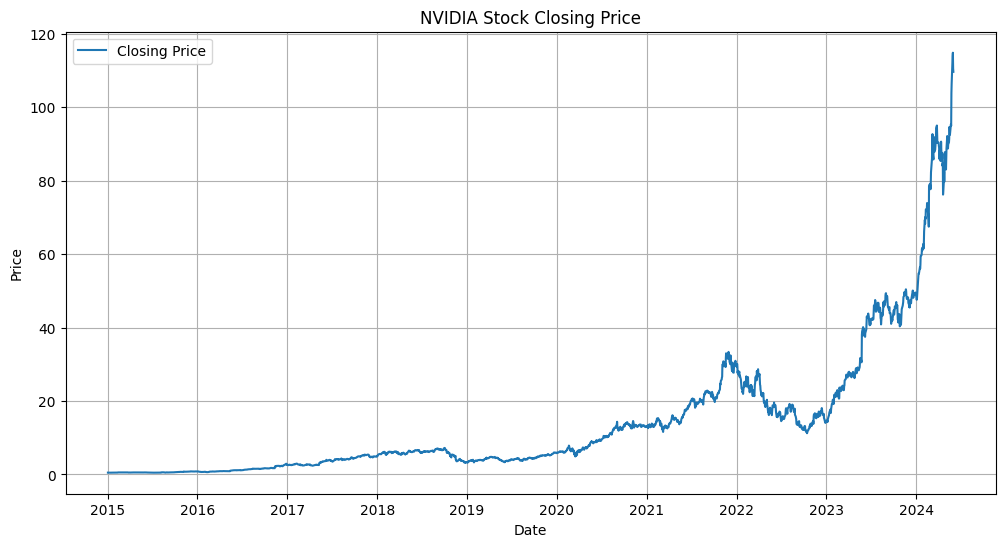

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("data/nvidia_stock_cleaned.csv")


df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Closing Price')
plt.title("NVIDIA Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


== Stationarity Check ==

ADF Statistic for Original Series: 4.9331
p-value: 1.0000

ADF Statistic for Differenced 1 times: -7.0218
p-value: 0.0000

Optimal d: 1

== Grid Search for SARIMA (p,d,q)x(P,D,Q,s) ==
✅ SARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC: 2948.63
✅ SARIMA(0, 1, 0)x(0, 1, 1, 7) - AIC: 1192.27
✅ SARIMA(0, 1, 0)x(1, 1, 0, 7) - AIC: 2294.62
✅ SARIMA(0, 1, 0)x(1, 1, 1, 7) - AIC: 1195.61
✅ SARIMA(0, 1, 1)x(0, 1, 0, 7) - AIC: 2923.85
✅ SARIMA(0, 1, 1)x(0, 1, 1, 7) - AIC: 1181.84
✅ SARIMA(0, 1, 1)x(1, 1, 0, 7) - AIC: 2265.95
✅ SARIMA(0, 1, 1)x(1, 1, 1, 7) - AIC: 1183.74
✅ SARIMA(0, 1, 2)x(0, 1, 0, 7) - AIC: 2907.97
✅ SARIMA(0, 1, 2)x(0, 1, 1, 7) - AIC: 1175.50
✅ SARIMA(0, 1, 2)x(1, 1, 0, 7) - AIC: 2250.18
✅ SARIMA(0, 1, 2)x(1, 1, 1, 7) - AIC: 1176.17
✅ SARIMA(1, 1, 0)x(0, 1, 0, 7) - AIC: 2928.60
✅ SARIMA(1, 1, 0)x(0, 1, 1, 7) - AIC: 1183.27
✅ SARIMA(1, 1, 0)x(1, 1, 0, 7) - AIC: 2271.78
✅ SARIMA(1, 1, 0)x(1, 1, 1, 7) - AIC: 1185.61
✅ SARIMA(1, 1, 1)x(0, 1, 0, 7) - AIC: 2731.94
✅ SARIMA

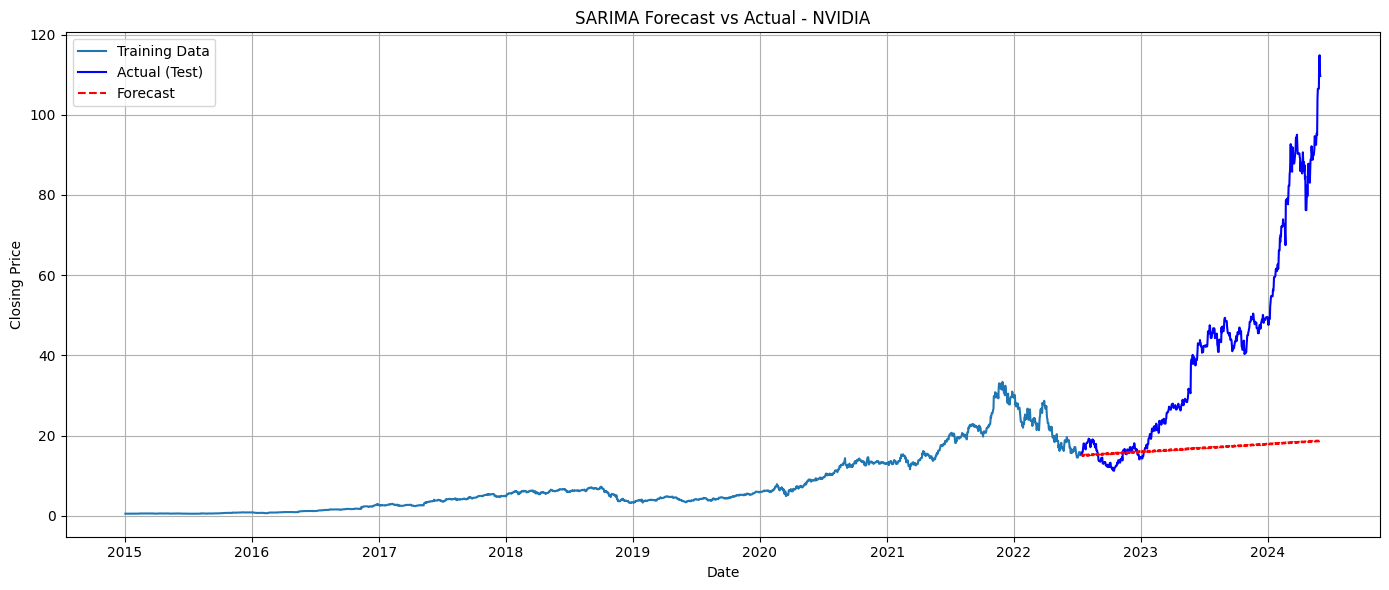

ImportError: cannot import name '_lazywhere' from 'scipy._lib._util' (c:\Users\HP\OneDrive\Desktop\TimeSeries_StockForecast\venv\Lib\site-packages\scipy\_lib\_util.py)

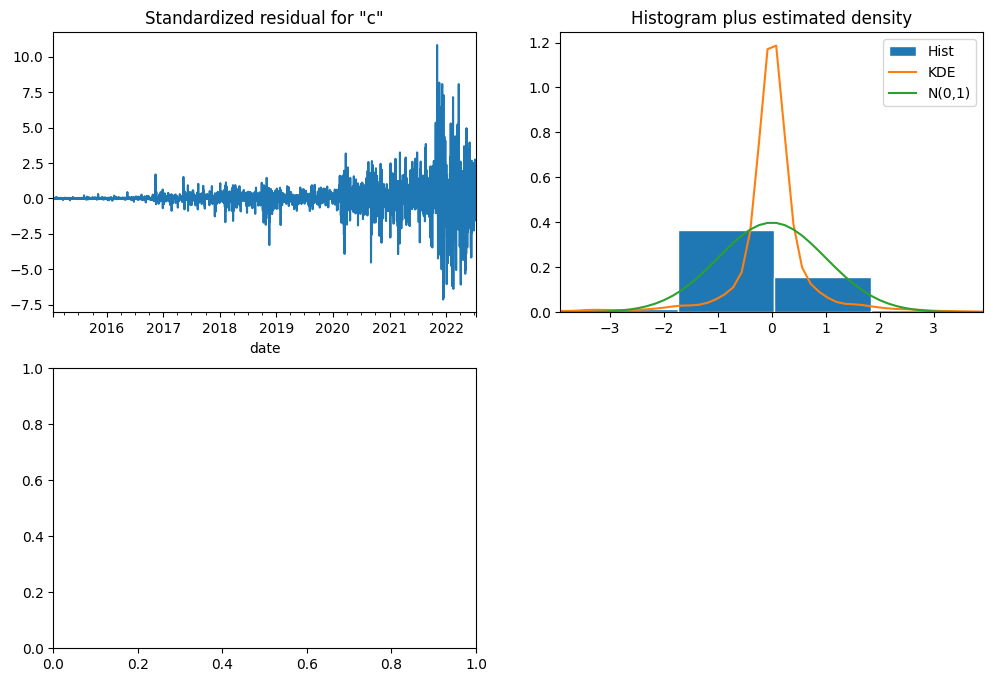

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# 1. Load and Prepare Data
df = pd.read_csv("data/nvidia_stock_cleaned.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
ts = df['close'].asfreq('D')  # daily frequency, forward fill missing if needed
ts = ts.fillna(method='ffill')

# 2. Check Stationarity
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'\nADF Statistic for {title}: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    return result[1]

print("== Stationarity Check ==")
d = 0
p_value = adf_test(ts, 'Original Series')
while p_value > 0.05:
    ts = ts.diff().dropna()
    d += 1
    p_value = adf_test(ts, f'Differenced {d} times')
print(f"\nOptimal d: {d}")

# 3. Train-Test Split
orig_ts = df['close'].asfreq('D').fillna(method='ffill')
train_size = int(len(orig_ts) * 0.8)
train, test = orig_ts[:train_size], orig_ts[train_size:]

# 4. SARIMA Grid Search
print("\n== Grid Search for SARIMA (p,d,q)x(P,D,Q,s) ==")
s = 7  # weekly seasonality
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

for p in range(0, 3):
    for q in range(0, 3):
        for P in range(0, 2):
            for Q in range(0, 2):
                try:
                    model = SARIMAX(train,
                                    order=(p, d, q),
                                    seasonal_order=(P, 1, Q, s),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
                    results = model.fit(disp=False)
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                        best_seasonal_order = (P, 1, Q, s)
                        best_model = results
                    print(f"✅ SARIMA{(p,d,q)}x{(P,1,Q,s)} - AIC: {results.aic:.2f}")
                except Exception as e:
                    print(f"❌ Failed SARIMA{(p,d,q)}x{(P,1,Q,s)}")
                    continue

print(f"\n✅ Best SARIMA Order: {best_order} x {best_seasonal_order} with AIC={best_aic:.2f}")

# 5. Forecast and Evaluate
forecast = best_model.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

# Drop NaNs if any
comparison = pd.DataFrame({'actual': test, 'forecast': forecast}).dropna()

# Evaluation
mae = mean_absolute_error(comparison['actual'], comparison['forecast'])
rmse = np.sqrt(mean_squared_error(comparison['actual'], comparison['forecast']))
print(f"\n== Evaluation ==")
print(f"MAE : {mae:.6f}")
print(f"RMSE: {rmse:.6f}")

# 6. Plot
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual (Test)', color='blue')
plt.plot(forecast.index, forecast, label='Forecast', color='red', linestyle='--')
plt.title("SARIMA Forecast vs Actual - NVIDIA")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Optional: Diagnostics
best_model.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()